In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
import math
import random
import nltk
from nltk.tokenize import TweetTokenizer,RegexpTokenizer,word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from string import punctuation
import re
import seaborn as sns
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import plot_confusion_matrix
import pickle
import emot
import contractions

In [12]:
def init():
    train = pd.read_csv("data/train.csv",encoding="iso-8859-1",header=None)
    test = pd.read_csv("data/test.csv",encoding="iso-8859-1",header=None)
    return train,test

# Pass data,column of text
def getVocab(train,col):
    vocab = {}
    count=0
    data = train[col].unique()
    for i in range(data.shape[0]):
        x = []
        words = data[i].replace("."," ").split(" ")
        if " " in words:
            words.remove(" ")
        for j in words:
            if(j not in vocab):
                vocab[j]=count
                count = count+1
    return vocab

# 0 = Negative 4 = Positive 2 = Neutral

# Pass the column of full data,column's number and vocabulary
def findParamVocab(data,vocab,col):
    v = vocab.fromkeys(vocab,1)
    total = len(vocab)
    data = data[col].unique()
    for i in data:
        words = i.replace("."," ").split(" ")
        while " " in words:
            words.remove(" ")
        while "" in words:
            words.remove("")
        total = total+len(words)
        for j in words:
            v[j] = v[j]+1
    for key in v:
        v[key] = float(v[key]/total)
    return v,total
    
def learnParam(train,vocab,col):
    m=train.shape[0]
    train4 = train[train[0]==4]
    train0 = train[train[0]==0]
    phi0 = (len(train0[col].unique()))/(m)
    phi4 = (len(train4[col].unique()))/(m)
    param0,t0 = findParamVocab(train[train[0]==0],vocab,col)
    param4,t4 = findParamVocab(train[train[0]==4],vocab,col)
    return phi0,phi4,param0,param4,t0,t4

# Pass the column of text
def findClasses(data,phi0,phi4,theta0,theta4,t0,t4):
    pred = []
    pred0 = []
    pred4 = []
    for i in data:
        prob0 = 0
        prob2 = 0
        prob4 = 0
        words = i.split(" ")
        if " " in words:
            words.remove(" ")
        for j  in words:
            try:
                prob0 = prob0+(math.log(theta0[j]))
            except:
                prob0 = prob0+math.log(float(1/(t0+1)))
            try:
                prob4 = prob4+(math.log(theta4[j]))
            except:
                prob4 = prob4+math.log(float(1/(t4+1)))
                
        prob0 = prob0+(math.log(phi0))
        prob4 = prob4+(math.log(phi4))
        if(prob0>prob4):
            pred.append(0)
        else:
            pred.append(4)
        pred0.append(prob0)
        pred4.append(prob4)
    return pred,pred0,pred4

def checkAccuracy(Y,pred):
    check = (Y==pred)
    t=0
    f=0
    for i in check:
        if i:
            t=t+1
        else:
            f=f+1
    print(t/(t+f))

def randomGuess(data):
    choices=[0,4]
    pred=[]
    for i in data:
        pred.append(random.choice(choices))
    return pred

def majorityGuess(train,test):
    c0 = train[train[0]==0][5].unique().shape[0]
    c4 = train[train[0]==4][5].unique().shape[0]
    m=0
    if(c0>c4):
        m=0
    else:
        m=4
    pred=[]
    for i in test[5]:
        pred.append(m)
    return pred

def confusionMatrix(test,prediction):
    mat = np.zeros((2,2))
    index=0
    for i in test[0]:
        mat[int(i/4)][int(prediction[index]/4)] = mat[int(i/4)][int(prediction[index]/4)]+1
        index=index+1
    return mat

def drawMatrix(matrix,title=""):
    df_cm = pd.DataFrame(matrix.astype(int), index = [i for i in "04"],columns = [i for i in "04"])
    plt.figure(figsize = (7,5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm,cmap="Blues", annot=True,fmt="d",linewidth=1,annot_kws={"size": 16})
    plt.title(title)
    plt.show()

def cleanText(data,col):
    temp = []
    for i in data[col]:
        words = contractions.fix(i.lower()).replace(","," ").replace(";"," ").replace("."," ").replace("!"," ").split(" ")
        temp.append(" ".join([stemmer.stem(j) for j in words if (stemmer.stem(j) not in stop and '@' not in j)]))
    data[6]=temp

# Pass data,column of text
def getAddedVocab(train,col):
    vocab = {}
    emoji = {}
    count=0
    emojiCount=0
    data = train[col].unique()
    for i in range(data.shape[0]):
        x = []
        words = data[i].split(" ")
        while " " in words:
            words.remove(" ")
        while "" in words:
            words.remove('')
        for j in words:
            if(j not in vocab):
                vocab[j]=count
                count = count+1
        for j in range(0,len(words)-1):
            if(words[j]+" "+words[j+1] not in vocab):
                vocab[words[j]+" "+words[j+1]]=count
                count = count+1
        try:
            for j in emot.emoticons(data[i])['value']:
                if(j not in emoji):
                    emoji[j]=emojiCount
                    emojiCount = emojiCount+1
        except:
            pass
    return vocab,emoji

# 0 = Negative 4 = Positive 2 = Neutral
# Pass the column of full data,column's number and vocabulary
def findAddedParamVocab(data,vocab,col):
    v = vocab.fromkeys(vocab,1)
    total = len(vocab)
    data = data[col].unique()
    for i in data:
        words = i.split(" ")
        while " " in words:
            words.remove(" ")
        while "" in words:
            words.remove("")
        total = total+2*len(words)-1
        for j in words:
            v[j] = v[j]+1
        for j in range(0,len(words)-1):
            v[words[j]+" "+words[j+1]] = v[words[j]+" "+words[j+1]]+1
    for key in v:
        v[key] = float(v[key]/total)
    v = {k: v for k, v in sorted(v.items(), key=lambda item: item[1],reverse=True)}
    return v,total

def findEmojiVocab(data,vocab,col):
    v = vocab.fromkeys(vocab,1)
    total = len(vocab)
    data = data[col].unique()
    for i in data:
        words = i.split(" ")
        while " " in words:
            words.remove(" ")
        while "" in words:
            words.remove("")
        try:
            for j in emot.emoticons(data[i])['value']:
                v[j]=v[j]+1
        except:
            pass
    for key in v:
        v[key] = float(v[key]/total)
    return v,total

def learnAddedParam(train,vocab,emoji,col):
    m=train.shape[0]
    train4 = train[train[0]==4]
    train0 = train[train[0]==0]
    phi0 = (len(train0[col].unique()))/(m)
    phi4 = (len(train4[col].unique()))/(m)
    param0,t0 = findAddedParamVocab(train[train[0]==0],vocab,col)
    emoji0,e0 = findEmojiVocab(train[train[0]==0],emoji,col)
    param4,t4 = findAddedParamVocab(train[train[0]==4],vocab,col)
    emoji4,e4 = findEmojiVocab(train[train[0]==4],emoji,col)
    return phi0,phi4,param0,param4,t0,t4,emoji0,e0,emoji4,e4

# Pass the column of text
def findAddedClasses(data,phi0,phi4,theta0,theta4,t0,t4,emoji0,emoji4,e0,e4):
    pred = []
    pred0 = []
    pred4 = []
    l0=[]
    count=0
    
    for i in theta0.keys():
        l0.append(i)
        if(count>100):
            break
        count+=1
    l4=[]
    count=0
    for i in theta4.keys():
        l4.append(i)
        if(count>100):
            break
        count+=1
    for i in data:
        prob0 = 0
        prob4 = 0
        words = i.split(" ")
        while " " in words:
            words.remove(" ")
        while "" in words:
            words.remove("")
        count0=1
        count4=1
        for j  in words:
            if j in l0:
                count0+=1
            try:
                prob0 = prob0+(math.log(theta0[j]))
            except:
                prob0 = prob0+math.log(float(1/(t0+1)))
            if j in l4:
                count4+=1
            try:
                prob4 = prob4+(math.log(theta4[j]))
            except:
                prob4 = prob4+math.log(float(1/(t4+1)))
        for j in range(0,len(words)-1):
            try:
                prob0 = prob0+(math.log(theta0[words[j]+" "+words[j+1]]))
            except:
                prob0 = prob0+math.log(float(1/(t0+1)))
            try:
                prob4 = prob4+(math.log(theta4[words[j]+" "+words[j+1]]))
            except:
                prob4 = prob4+math.log(float(1/(t4+1)))
        flag=0
        try:
            for j in emot.emoticons(i)['value']:
                flag=1
                prob0=prob0+math.log(emoji0[j])
                prob4=prob4+math.log(emoji4[j])
        except:
            pass
        if(flag==0):
            prob0 = prob0+math.log(float(1/(e0+1)))
            prob4 = prob4+math.log(float(1/(e4+1)))
        prob0 = prob0+(math.log(phi0))+math.log((count0/101))
        prob4 = prob4+(math.log(phi4))+math.log((count4/101))
        if(prob0>prob4):
            pred.append(0)
        else:
            pred.append(4)
        pred0.append(prob0)
        pred4.append(prob4)
    return pred,pred0,pred4

def tfidfVectorizer(clf,X,data):
    for i in tqdm(range(0,data.shape[0]//1000)):
        clf.partial_fit(X[1000*i:1000*(i+1)].todense(),data[0][1000*i:1000*(i+1)],classes=np.array([0,4]))
    return clf

def rocCurve(data,prob0,prob4):
    y = label_binarize(data[0],classes=[0,4])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr[0], tpr[0], _ = roc_curve(y,prob0)
    roc_auc[0] = auc(fpr[0], tpr[0])
    fpr[1], tpr[1], _ = roc_curve(y,prob4)
    roc_auc[1] = auc(fpr[1], tpr[1])
    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label='ROC curve for Class 0(area = %0.2f)' % roc_auc[0])
    plt.plot(fpr[1], tpr[1], color='cyan',lw=lw, label='ROC curve for Class 1(area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [6]:
train,test = init()

# PART A

t = time()
vocab = getVocab(train,5)
# print(len(vocab))
phi0,phi4,theta0,theta4,t0,t4 = learnParam(train,vocab,5)
predictionTrain,pred0,pred4 = findClasses(train[5],phi0,phi4,theta0,theta4,t0,t4)
print("Prediction Train",time()-t)
checkAccuracy(train[0],predictionTrain)

test = test[test[0]==0].append(test[test[0]==4])
predictionTest,predTest0,predTest4 = findClasses(test[5],phi0,phi4,theta0,theta4,t0,t4)
print("Prediction Test")
checkAccuracy(test[0],predictionTest)

Prediction Train 28.34186887741089
0.84568125
Prediction Test
0.8022284122562674


Random Guess
0.49303621169916434
Majority Guess
0.5069637883008357


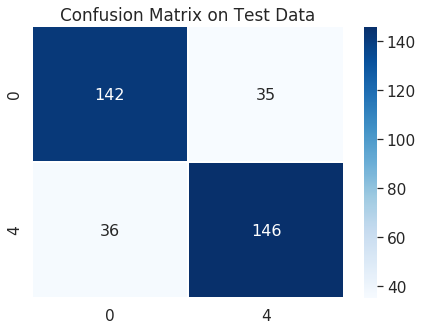

In [9]:
predictionRandom = randomGuess(test[5])
print("Random Guess")
checkAccuracy(test[0],predictionRandom)

predictionMajority = majorityGuess(train,test)
print("Majority Guess")
checkAccuracy(test[0],predictionMajority)

matrix = confusionMatrix(test,predictionTest)
drawMatrix(matrix,"Confusion Matrix on Test Data")

Data Cleaned 466.3169538974762


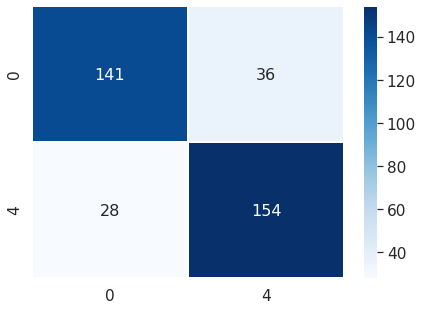

Prediction on Clean Test
0.8217270194986073
Prediction on Clean Train
0.8008575


In [10]:
stop = set(stopwords.words("english"))
stemmer = PorterStemmer()

st=time()
cleanText(train,5)
print("Data Cleaned",time()-st)

vocabClean = getVocab(train,6)
Cphi0,Cphi4,Ctheta0,Ctheta4,Ct0,Ct4 = learnParam(train,vocabClean,6)
cleanText(test,5)
predictionTestClean,CpredTest0,CpredTest4 = findClasses(test[6],Cphi0,Cphi4,Ctheta0,Ctheta4,Ct0,Ct4)

matrix = confusionMatrix(test,predictionTestClean)
drawMatrix(matrix)
print("Prediction on Clean Test")
checkAccuracy(test[0],predictionTestClean)

predictionTrainClean,CpredTrain0,CpredTrain4 = findClasses(train[6],Cphi0,Cphi4,Ctheta0,Ctheta4,Ct0,Ct4)
print("Prediction on Clean Train")
checkAccuracy(train[0],predictionTrainClean)

In [13]:
# PART E

st = time()
addedVocab,emojiVocab = getAddedVocab(train,6)
print("Added Vocabulary",time()-st)

phiF0,phiF4,thetaF0,thetaF4,tF0,tF4,emoji0,e0,emoji4,e4 = learnAddedParam(train,addedVocab,emojiVocab,6)
predictionAddedTrain,predAdded0,predAdded4 = findAddedClasses(train[6],phiF0,phiF4,thetaF0,thetaF4,tF0,tF4,emoji0,emoji4,e0,e4)

print("Prediction on train after adding features")
checkAccuracy(train[0],predictionAddedTrain)

test = test[test[0]==0].append(test[test[0]==4])
predictionAddedTest,predAddedTest0,predAddedTest4 = findAddedClasses(test[6],phiF0,phiF4,thetaF0,thetaF4,tF0,tF4,emoji0,emoji4,e0,e4)
print("Prediction on test after adding features")
checkAccuracy(test[0],predictionAddedTest)

Added Vocabulary 82.70262503623962
Prediction on train after adding features
0.9014525
Prediction on test after adding features
0.841225626740947


In [14]:
# PART F

tfidf = TfidfVectorizer(min_df=0.0007)
clf = GaussianNB()
X = tfidf.fit_transform(train[6])
clf = tfidfVectorizer(clf,X,train)
Y = tfidf.transform(test[6])
testDense = Y.todense()
predictionTestTfidf = clf.predict(testDense)
logProbaTest = clf.predict_log_proba(testDense)

tfidf = TfidfVectorizer(min_df=0.0007)
X = tfidf.fit_transform(train[6])
multiClf = MultinomialNB()
multiClf.fit(X,train[0])
Y = tfidf.transform(test[6])
testDense = Y.todense()
predictionTestmulti = multiClf.predict(testDense)
logProbaTestMulti = clf.predict_log_proba(testDense)

print("Accuracy over GaussianNB")
checkAccuracy(test[0],predictionTestTfidf)
print("Accuracy over MultinomialNB")
checkAccuracy(test[0],predictionTestmulti)

tfidf = TfidfVectorizer(min_df=200)
X = tfidf.fit_transform(train[6])
Y = train[0]
percentile = SelectPercentile(chi2, percentile=10)
selectedData = percentile.fit_transform(X,Y)

clf2 = GaussianNB()
per10 = tfidfVectorizer(clf2,selectedData,train)

testData = tfidf.transform(test[6])
testDense10per = percentile.transform(testData)
prediction10per = clf2.predict(testDense10per.todense())
logProbaTestPer = clf2.predict_log_proba(testDense10per.todense())
print("Percentile Selected: 10per")
checkAccuracy(test[0],prediction10per)

100%|██████████| 1600/1600 [00:22<00:00, 71.88it/s]


Accuracy over GaussianNB
0.8105849582172702
Accuracy over MultinomialNB
0.8050139275766016


100%|██████████| 1600/1600 [00:06<00:00, 228.72it/s]

Percentile Selected: 10per
0.7688022284122563


In [ ]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(train[6])
Y = train[0]
percentile = SelectPercentile(chi2, percentile=2)
selectedData = percentile.fit_transform(X,Y)

clf2 = GaussianNB()
per10 = tfidfVectorizer(clf2,selectedData,train)

testData = tfidf.transform(test[6])
testDense10per = percentile.transform(testData)
prediction10per = clf2.predict(testDense10per.todense())
logProbaTestPer = clf2.predict_log_proba(testDense10per.todense())
print("Percentile Selected: 10per")
checkAccuracy(test[0],prediction10per)

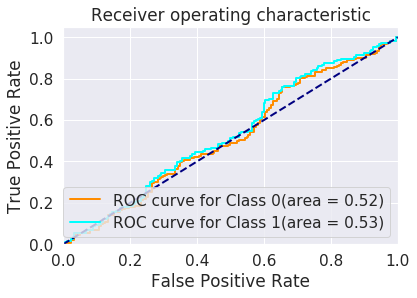

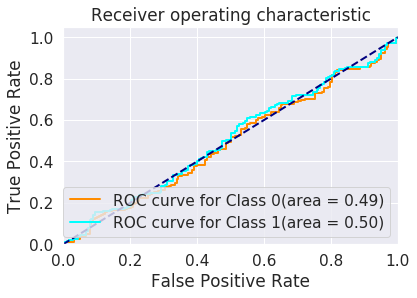

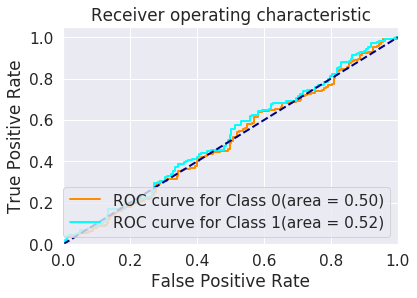

In [15]:
# PART G

# rocCurve(train,pred0,pred4)
rocCurve(test,predTest0,predTest4)
rocCurve(test,CpredTest0,CpredTest4)
rocCurve(test,predAddedTest0,predAddedTest4)
# rocCurve(test,-logProbaTest[:,0],logProbaTest[:,1])